# Tradução utilizando Attention
> Baseado no artigo [Attention is all you need](https://arxiv.org/abs/1706.03762).

O Transformador - para facilitar o entendimento daqueles com um conhecimento prévio em redes neurais, chamaremos de "Transformer" assim como na literatura original - do artigo "Attention is all you need" têm estado na mente de várias pessoas desde que foi escrito no ano de 2017. Além de produzir grandes melhorias na qualidade da tradução, fornece uma arquitetura para muitas outras tarefas de NLP ( Natural Language Processing ). O artigo em si está escrito de forma muito clara, mas os leitores comentam que é muito difícil de implementá-lo corretamente.

Nesse notebook apresentamos uma implementação, tentando comentar linha por linha. Reorganizamos e excluímos algumas seções do artigo original e adicionamos comentários onde pensamos ser necessário.

Vale mencionar que, no original, existem cerca 400 linhas de código de biblioteca que podem processar 27.000 tokens por segundo em 4 GPUs, mas como não contamos com esse poder computacional, implementamos uma versão que funcione com apenas 1 GPU, caso quem for rodar esse código possua uma, do contrário será usado a CPU.

O código apresentado aqui é fortemente baseado nos pacotes [OpenNMT](https://opennmt.net/). Para outras implementações de serviço completas do modelo, vale conferir [Tensor2Tensor (Tensorflow)](https://github.com/tensorflow/tensor2tensor) e [Sockeye (mxnet)](https://github.com/awslabs/sockeye).

## Bibliotecas

In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import nltk
from nltk.translate.bleu_score import sentence_bleu
nltk.download('punkt')

import math, copy, time

import matplotlib.pyplot as plt
import seaborn
seaborn.set_context(context = "talk")

from IPython.display import Image

%matplotlib inline

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Breve background
O objetivo de reduzir a computação sequencial também forma a base do [Extended Neural GPU](https://www.researchgate.net/publication/309631810_Extensions_and_Limitations_of_the_Neural_GPU), [ByteNet](https://sh-tsang.medium.com/review-neural-machine-translation-in-linear-time-bytenet-e5a50bfb462b) e [ConvS2S](https://sh-tsang.medium.com/review-convolutional-sequence-to-sequence-learning-convs2s-510a9eddce05), que usam redes neurais convolucionais como bloco de construção básico, computando representações ocultas em paralelo para todas as posições de entrada e saída. Nesses modelos, o número de operações necessárias para relacionar sinais de duas posições arbitrárias de entrada ou saída cresce na distância entre as posições, linearmente para ConvS2S e logaritmicamente para ByteNet. Isso torna mais difícil aprender dependências entre posições distantes. No Transformer, isso é reduzido a um número constante de operações, embora ao custo de uma resolução efetiva reduzida devido à média das posições ponderadas de atenção, um efeito que é neutralizado com a Atenção de Múltiplas Cabeças ( Multi-Head ).

A autoatenção, às vezes chamada de intra-atenção, é um mecanismo de atenção que relaciona diferentes posições de uma única sequência para computar uma representação da sequência. A autoatenção tem sido usada com sucesso em uma variedade de tarefas, incluindo compreensão de leitura, resumo de abstratos, vinculação textual e representações de sentenças independentes da tarefa de aprendizagem. As redes de memória de ponta a ponta são baseadas em um mecanismo de atenção recorrente em vez de recorrência alinhada por sequência e têm demonstrado um bom desempenho em respostas a perguntas de linguagem simples e tarefas de modelagem de linguagem.

Até onde sabemos, no entanto, o Transformer é o primeiro modelo de tradução que depende inteiramente da autoatenção para calcular as representações de sua entrada e saída sem usar redes neurais recorrentes alinhadas à sequência ou convolução.


## Arquitetura do modelo
A maioria dos modelos neurais competitivos de tradução de sequência tem uma estrutura [codificador-decodificador (Encoder-Decoder)](https://arxiv.org/abs/1409.0473). Aqui, o codificador mapeia uma sequência de entrada de representações de símbolos $ (x_1, ..., x_n) $ para uma sequência de representações contínuas $ z = (z_1, ..., z_n) $. Dado $ z $, o decodificador então gera uma sequência de saída $ (y_1, ..., y_m) $ de símbolos um elemento por vez. A cada passo, o modelo é [auto-regressivo](https://arxiv.org/abs/1308.0850), consumindo os símbolos gerados anteriormente como entrada adicional quando gerando o próximo.

In [3]:
class EncoderDecoder(nn.Module):
    '''
    A standard Encoder-Decoder architecture. 
    Base for this and many other models.
    '''
    def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.generator = generator
        
    def forward(self, src, tgt, src_mask, tgt_mask):
        '''
        Take in and process masked src and target sequences.
        '''
        return self.decode(self.encode(src, src_mask), 
                           src_mask, tgt, tgt_mask)
    
    def encode(self, src, src_mask):
        return self.encoder(self.src_embed(src), src_mask)
    
    def decode(self, memory, src_mask, tgt, tgt_mask):
        return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)

In [4]:
class Generator(nn.Module):
    '''
    Define standard linear + softmax generation step.
    '''
    def __init__(self, d_model, vocab):
        super(Generator, self).__init__()
        self.proj = nn.Linear(d_model, vocab)

    def forward(self, x):
        return F.log_softmax(self.proj(x), dim = -1)

O Transformer segue essa arquitetura geral usando camadas de autoatenção empilhadas e totalmente conectadas por pontos para o codificador e o decodificador, mostradas nas metades esquerda e direita da figura abaixo, respectivamente.

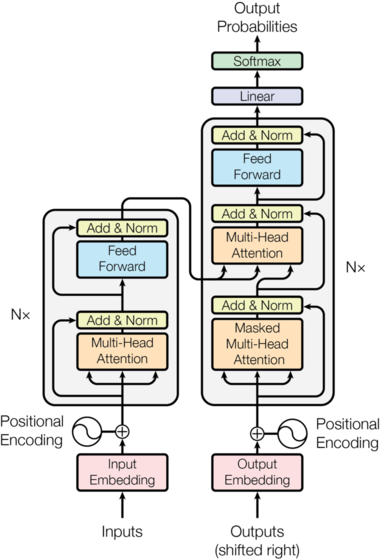

In [5]:
Image(filename='Imagens/architecture.png')

## Pilhas de Encoder e Decoder

### Encoder
O enconder é composto de uma pilha de $ N = 6 $ camadas idênticas.

In [6]:
def clones(module, N):
    '''
    Produce N identical layers.
    '''
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

In [7]:
class Encoder(nn.Module):
    '''
    Core encoder is a stack of N layers
    '''
    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x, mask):
        '''
        Pass the input (and mask) through each layer in turn.
        '''
        for layer in self.layers:
            x = layer(x, mask)
            
        return self.norm(x)

Empregamos uma [conexão residual](https://arxiv.org/abs/1512.03385) em torno de cada uma das duas subcamadas, seguida da [normalização de camada](https://arxiv.org/abs/1607.06450).

In [8]:
class LayerNorm(nn.Module):
    '''
    Construct a layernorm module
    '''
    def __init__(self, features, eps = 1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim = True)
        std = x.std(-1, keepdim = True)
        
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2

Isto é, a saída de cada subcamada é $ LayerNorm(x + Sublayer(x)) $, em que $ Sublayer(x) $ é a função implementada na própria subcamada. Aplicamos [dropout](https://jmlr.org/papers/v15/srivastava14a.html) na saída de cada subcamada, antes de ser adicionada à entrada da subcamada e normalizada.

Para facilitar essas conexões residuais, todas as subcamadas do modelo, tanto quanto as camadas para os embedding, produzem saídas de dimensão $ d_{model} = 512 $.

In [9]:
class SublayerConnection(nn.Module):
    '''
    A residual connection followed by a layer norm.
    Note for code simplicity the norm is first as opposed to last.
    '''
    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        '''
        Apply residual connection to any sublayer with the same size.
        '''
        return x + self.dropout(sublayer(self.norm(x)))

Cada camada tem duas subcamadas. A primeira é um mecanismo de autoatenção de múltiplas cabeças, e a segunda é uma rede feed-forward simples e totalmente conectada em termos de posição.


In [10]:
class EncoderLayer(nn.Module):
    '''
    Encoder is made up of self-attn and feed forward (defined below)
    '''
    def __init__(self, size, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 2)
        self.size = size

    def forward(self, x, mask):
        '''
        Follow figure above for connections
        '''
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
        
        return self.sublayer[1](x, self.feed_forward)

### Decoder
O decoder também será composto de uma pilha de $ N = 6 $ camadas idênticas.

In [11]:
class Decoder(nn.Module):
    '''
    Generic N layer decoder with masking.
    '''
    def __init__(self, layer, N):
        super(Decoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x, memory, src_mask, tgt_mask):
        for layer in self.layers:
            x = layer(x, memory, src_mask, tgt_mask)
        
        return self.norm(x)

Além das duas subcamadas em cada camada do codificador, o decodificador insere uma terceira subcamada, que realiza a atenção de múltiplas cabeças sobre a saída da pilha do codificador. Semelhante ao codificador, empregamos conexões residuais em torno de cada uma das subcamadas, seguidas de normalização de camada.

In [12]:
class DecoderLayer(nn.Module):
    '''
    Decoder is made of self-attn, src-attn, and feed forward (defined below)
    '''
    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
        super(DecoderLayer, self).__init__()
        self.size = size
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 3)
 
    def forward(self, x, memory, src_mask, tgt_mask):
        m = memory
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask))
        x = self.sublayer[1](x, lambda x: self.src_attn(x, m, m, src_mask))
        
        return self.sublayer[2](x, self.feed_forward)

Também modificamos a subcamada de autoatenção na pilha do decodificador para evitar que as posições atendam às posições subsequentes. Esse mascaramento, combinado com o fato de que os embeddings de saída são deslocados em uma posição, garante que as previsões de posição $ i $ pode depender apenas das saídas conhecidas em posições menores que $ i $.


In [13]:
def subsequent_mask(size):
    '''
    Mask out subsequent positions.
    '''
    attn_shape = (1, size, size)
    subsequent_mask = np.triu(np.ones(attn_shape), k = 1).astype('uint8')
    
    return torch.from_numpy(subsequent_mask) == 0

Abaixo a máscara de atenção mostra a posição que cada palavra alvo, por linha, pode olhar, representada pela coluna. As palavras são bloqueadas para atender a futuras palavras durante o treinamento.

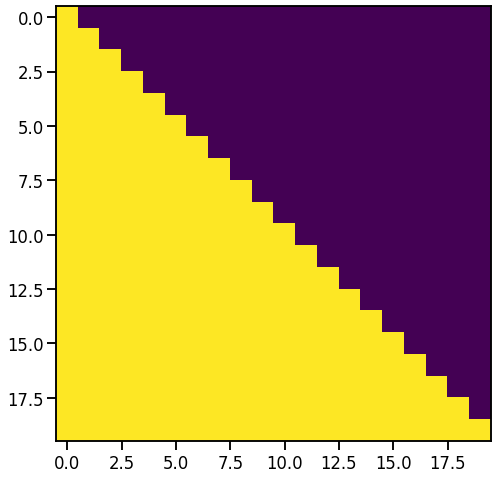

In [14]:
plt.figure(figsize = (8, 8))
plt.imshow(subsequent_mask(20)[0])
plt.show()

## Attention
Uma função de atenção pode ser descrita como o mapeamento de uma consulta e um conjunto de pares chave-valor para uma saída, onde a consulta, as chaves, os valores e a saída são todos vetores. A saída é calculada como uma soma ponderada dos valores, em que o peso atribuído a cada valor é calculado por uma função de compatibilidade da consulta com a chave correspondente.

Chamamos nossa atenção particular de “Atenção de produto interno escalonado” (Scaled Dot-Product Attention). A entrada consiste em consultas e chaves de dimensão $ d_k $, e valores de dimensão $ d_v $. Calculamos os produtos internos da consulta com todas as chaves, dividimos cada um por $ \sqrt{d_k} $, e aplicamos a [função softmax](https://developers.google.com/machine-learning/crash-course/multi-class-neural-networks/softmax) para obter os pesos dos valores.


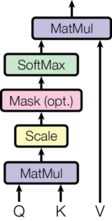

In [15]:
Image(filename='Imagens/attention.png')

Na prática, calculamos a função de atenção num conjunto de consultas simultaneamente, agrupadas numa matriz $ Q $. As chaves e valores também são colocadas juntas em matrizes $ K $ e $ V $. Calculamos a matriz de saídas da seguinte forma:

$ 
\mathrm{Attention}(Q, K, V) = \mathrm{softmax}(\frac{QK^T}{\sqrt{d_k}})V 
$

In [16]:
def attention(query, key, value, mask = None, dropout = None):
    '''
    Compute 'Scaled Dot Product Attention'
    '''
    d_k = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1))/ math.sqrt(d_k)

    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
    
    p_attn = F.softmax(scores, dim = -1)
    
    if dropout is not None:
        p_attn = dropout(p_attn)
    
    return torch.matmul(p_attn, value), p_attn

As duas funções de atenção mais utilizadas são a [atenção aditiva](https://arxiv.org/abs/1409.0473), e a atenção por produto interno (ou atenção multiplicativa). A atenção por produto interno é idêntica ao algoritmo apresentado, exceto pelo fator de escalonamento de $ \frac{1}{\sqrt{d_k}} $. Atenção aditiva calcula a função de compatibilidade utilizando a rede feed-forward com uma única camada oculta (hidden layer). Enquanto as duas são similares em complexidade teórica, atenção por produto interno é muito mais rápida e mais eficiente em termos de espaço na prática, pois pode ser implementada utilizando código de multiplicação de matriz altamente otimizado.

Enquanto que para valores pequenos de $ d_k $ os dois mecanismos performam de maneira similar, [atenção aditiva supera a atenção por produto interno sem escalar para maiores valores de $ d_k $](https://arxiv.org/abs/1703.03906). A suspeita dos autores é de que para maiores valores de $ d_k $, os produtos internos crescem em magnitude, empurrando a função softmax para regiões em que ela possui gradientes extremamente pequenos (para ilustrar o porquê dos produtos internos cresceram, assuma que os componentes de $ q $ e $ k $ sejam variáveis independetes aleatórias com média 0 e variância 1. Então, o produto interno deles, $ q \cdot k = \sum_{i=1}^{d_k} q_ik_i $, tem média 0 e variância $ d_k $ ). Para contra-atacar esse efeito, escalonamos o produto interno por $ \frac{1}{\sqrt{d_k}} $.

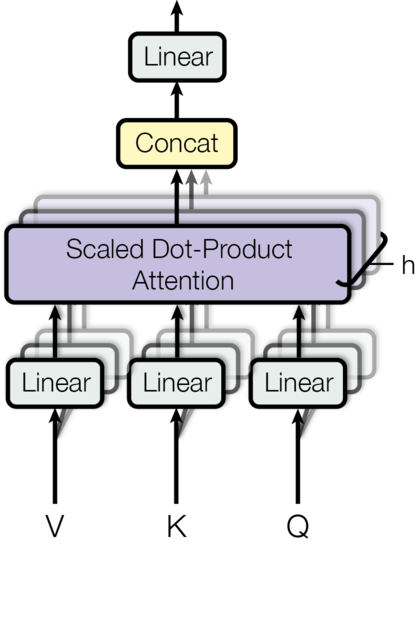

In [17]:
Image(filename='Imagens/multi-head.png')

Atenção de Múltiplicas Cabeças (Multi-head attention) permite que o modelo atenda conjuntamente a informações de diferentes subespaços de representação em diferentes posições. Com atenção de uma única cabeça, o cálculo da média inibe isso.

$
\mathrm{MultiHead}(Q, K, V) = \mathrm{Concat}(\mathrm{head_1}, ...,
\mathrm{head_h})W^O    \\
    \text{em que}~\mathrm{head_i} = \mathrm{Attention}(QW^Q_i, KW^K_i, VW^V_i)
$

Em que as projeções são matrizes de parâmetros $ W^Q_i \in \mathbb{R}^{d_{\text{model}} \times d_k} $, $ W^K_i \in \mathbb{R}^{d_{\text{model}} \times d_k} $, $ W^V_i \in \mathbb{R}^{d_{\text{model}} \times d_v} $ e $ W^O \in \mathbb{R}^{hd_v \times d_{\text{model}}} $. Nesse trabalho, são utilizadas $ h = 8 $ camadas de atenção paralelas, ou "cabeças". Para cada uma dessas é usado $ d_k = d_v = d_{model}/ h = 64 $. Devido à dimensão reduzida de cada cabeça, o custo computacional total é semelhante ao da atenção de cabeça única com dimensionalidade total. 

In [18]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout):
        '''
        Take in model size and number of heads.
        '''
        super(MultiHeadedAttention, self).__init__()
        
        assert d_model % h == 0
        
        # We assume d_v always equals d_k
        self.d_k = d_model // h
        self.h = h
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, query, key, value, mask = None):
        '''
        Implements figure above
        '''
        if mask is not None:
            # Same mask applied to all h heads.
            mask = mask.unsqueeze(1)

        nbatches = query.size(0)
        
        # 1) Do all the linear projections in batch from d_model => h x d_k 
        query, key, value = [
            l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
            for l, x in zip(self.linears, (query, key, value))
        ]
        
        # 2) Apply attention on all the projected vectors in batch. 
        x, self.attn = attention(query, key, value, mask = mask, dropout = self.dropout)
        
        # 3) "Concat" using a view and apply a final linear. 
        x = x.transpose(1, 2).contiguous().view(nbatches, -1, self.h * self.d_k)
        
        return self.linears[-1](x)

### Aplicações de Atenção no nosso Modelo
O Transformer usa Multi-Head attention em três maneiras diferentes:

1. nas camadas de atenção "encoder-decoder", as consultas vêm da camada do decodificador anterior e as chaves de memória e os valores vêm da saída do codificador. Isso permite que cada posição no decodificador atenda a todas as posições na sequência de entrada. Isso imita [os mecanismos típicos de atenção do codificador-decodificador em modelos de sequência para sequência (sequence-to-sequence)](https://arxiv.org/abs/1609.08144);
2. o codificador contém camadas de autoatenção. Em uma camada de autoatenção todas as chaves, valores e consultas vêm do mesmo local, neste caso, a saída da camada anterior no codificador. Cada posição no codificador pode atender a todas as posições na camada anterior do codificador;
3. da mesma forma, as camadas de autoatenção no decodificador permitem que cada 
posição no decodificador atenda a todas as posições no decodificador até essa posição, inclusive. Precisamos evitar o fluxo de informações para a esquerda no decodificador para preservar a propriedade auto-regressiva. Implementamos isso dentro da atenção de produto escalar escalonado, mascarando (definindo como $- \infty $) todos os valores na entrada do softmax que correspondem a conexões ilegais.


### Position-wise Feed-Forward Networks
Além das subcamadas de atenção, cada uma das camadas em nosso codificador e decodificador contém uma rede feed-forward totalmente conectada, que é aplicada a cada posição separadamente e de forma idêntica. Ela consiste em duas transformações lineares com uma [ativação ReLU](https://machinelearningmastery.com/rectified-linear-activation-function-for-deep-learning-neural-networks/) no meio.

$ 
\mathrm{FFN}(x)=\max(0, xW_1 + b_1) W_2 + b_2 
$

Embora as transformações lineares sejam as mesmas em diferentes posições, elas usam parâmetros diferentes de camada para camada. Outra maneira de descrever isso é como duas convoluções com tamanho de kernel igual à 1. A dimensionalidade de entrada e saída é $ d_{model}= 512 $, e a camada interna tem dimensionalidade $ d_{ff} = 2048 $.


In [19]:
class PositionwiseFeedForward(nn.Module):
    '''
    Implements FFN equation.
    '''
    def __init__(self, d_model, d_ff, dropout):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w_2(self.dropout(F.relu(self.w_1(x))))

### Embeddings e Softmax
Da mesma forma que outros modelos de tradução de sequência, usamos embeddings pré-treinados para converter os tokens de entrada e os tokens de saída em vetores de dimensão $ d_{model} $. Também usamos a transformação linear pré-treinada usual e a função softmax para converter a saída do decodificador em probabilidades previstas do próximo token. Em nosso modelo, [compartilhamos a mesma matriz de peso entre as duas camadas de embedding e a transformação linear pré-softmax](https://arxiv.org/abs/1608.05859). Nas camadas de embedding, multiplicamos esses pesos por $ \sqrt{d_{model}} $. 

In [20]:
class Embeddings(nn.Module):
    def __init__(self, d_model, vocab):
        super(Embeddings, self).__init__()
        self.lut = nn.Embedding(vocab, d_model)
        self.d_model = d_model

    def forward(self, x):
        return self.lut(x) * math.sqrt(self.d_model)

### Positional Encoding
Como nosso modelo não contém recorrência e nem convolução, para que o modelo faça uso da ordem da sequência, devemos injetar algumas informações sobre a posição relativa ou absoluta dos tokens na sequência. Para isso, adicionamos “codificações posicionais” aos embeddings de entrada na parte inferior das pilhas do codificador e do decodificador. As codificações posicionais têm a mesma dimensão $d_{model} $ dos embeddings, para que os dois possam ser somados. [Há muitas escolhas de codificação posicional, pré-treinada e fixa](https://arxiv.org/pdf/1705.03122.pdf).

Neste trabalho, usamos funções seno e cosseno de diferentes frequências: 

$ 
PE_{(pos,2i)} = sin(pos / 10000^{2i/d_{\text{model}}}) 
$ 
$ 
PE_{(pos,2i+1)} = cos(pos / 10000^{2i/d_{\text{model}}}) 
$ em que $ pos $ é a posição e $ i $ é a dimensão. Isto é, cada dimensão de codificação posicional corresponde à uma sinusóide. Os comprimentos de onda formam uma progressão geométrica de $ 2 \pi $ até $ 10.000 \times 2 \pi$. Essa função foi escolhida pois os autores do artigo original hipotetizaram que ela permitiria o modelo aprender facilmente a atender por posições relativas, já que para qualquer deslocamento fixo $ k $, $ PE_{pos+k} $ pode ser representado como uma função linear de $ PE_{pos} $.

Além disso, aplicamos dropout às somas dos embeddings e das codificações posicionais nas pilhas do codificador e do decodificador. Para o modelo base, usamos uma taxa de $ P_{drop} = 0.1 $.

In [21]:
class PositionalEncoding(nn.Module):
    '''
    Implement the PE function.
    '''
    def __init__(self, d_model, dropout, max_len = 5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        x = x + Variable(self.pe[:, :x.size(1)], requires_grad=False)
        return self.dropout(x)

Abaixo a codificação posicional será adicionada a uma onda senoidal com base na posição. A frequência e o deslocamento da onda são diferentes para cada dimensão.

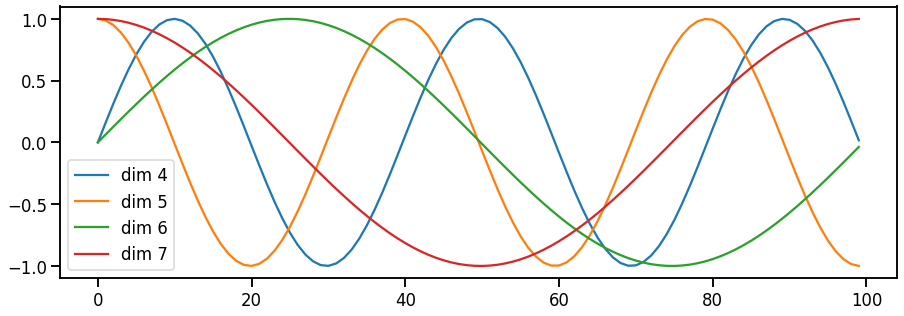

In [22]:
plt.figure(figsize = (15, 5))

pe = PositionalEncoding(20, 0)
y = pe.forward(Variable(torch.zeros(1, 100, 20)))

plt.plot(np.arange(100), y[0, :, 4:8].data.numpy())
plt.legend(["dim %d"%p for p in [4, 5, 6, 7]])
plt.show()

Os autores originais também experimentaram o uso de [incorporações posicionais pré-treinadas](https://arxiv.org/pdf/1705.03122.pdf) e descobriram que as duas versões produziram resultados quase idênticos. Para esse trabalho foi escolhida a versão senoidal porque ela pode permitir que o modelo extrapole para comprimentos de sequência maiores do que os encontrados durante o treinamento.


## Modelo completo
Aqui definimos uma função que recebe hiperparâmetros e produz um modelo completo.

### Hiperparâmetros

In [23]:
n_epochs = 2
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
BATCH_SIZE = 256

# modelo
N = 6
d_model = 512
d_ff = 2048
h = 8
dropout = 0.1
V = 11

# otimizador
lr = 0 
betas = (0.9, 0.98)
eps = 1e-9
factor = 1
warmup_steps = 4000

# suavização
smoothing = 0.0

In [24]:
def make_model(src_vocab, tgt_vocab, N, d_model, d_ff, h, dropout):
    '''
    Helper: Construct a model from hyperparameters.
    '''
    c = copy.deepcopy
    
    attn = MultiHeadedAttention(h, d_model, dropout)
    ff = PositionwiseFeedForward(d_model, d_ff, dropout)
    position = PositionalEncoding(d_model, dropout)
    
    model = EncoderDecoder(
        Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
        Decoder(DecoderLayer(d_model, c(attn), c(attn), c(ff), dropout), N),
        nn.Sequential(Embeddings(d_model, src_vocab), c(position)),
        nn.Sequential(Embeddings(d_model, tgt_vocab), c(position)),
        Generator(d_model, tgt_vocab)
    )
    
    # This was important from their code. 
    # Initialize parameters with Glorot / fan_avg.
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)
    
    return model

In [25]:
# Small example model.
tmp_model = make_model(2, 2, N = N, d_model = d_model, d_ff = d_ff, h = h, dropout = dropout).to(device)
tmp_model

EncoderDecoder(
  (encoder): Encoder(
    (layers): ModuleList(
      (0): EncoderLayer(
        (self_attn): MultiHeadedAttention(
          (linears): ModuleList(
            (0): Linear(in_features=512, out_features=512, bias=True)
            (1): Linear(in_features=512, out_features=512, bias=True)
            (2): Linear(in_features=512, out_features=512, bias=True)
            (3): Linear(in_features=512, out_features=512, bias=True)
          )
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (feed_forward): PositionwiseFeedForward(
          (w_1): Linear(in_features=512, out_features=2048, bias=True)
          (w_2): Linear(in_features=2048, out_features=512, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (sublayer): ModuleList(
          (0): SublayerConnection(
            (norm): LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): SublayerConnection(
            (norm): LayerNorm()

## Treinamento
Esta seção descreve o regime de treinamento para nossos modelos.

### Batches e Masking
Paramos para um breve interlúdio para apresentar algumas das ferramentas necessárias para treinar um modelo de decodificador de codificador padrão. Primeiro, definimos um objeto batch que contém as sentenças src e target para treinamento, além de construir as máscaras.

In [26]:
class Batch:
    '''
    Object for holding a batch of data with mask during training."
    '''
    def __init__(self, src, trg = None, pad = 0):
        self.src = src
        self.src_mask = (src != pad).unsqueeze(-2)
        
        if trg is not None:
            self.trg = trg[:, :-1]
            self.trg_y = trg[:, 1:]
            self.trg_mask = self.make_std_mask(self.trg, pad)
            self.ntokens = (self.trg_y != pad).data.sum()
    
    @staticmethod
    def make_std_mask(tgt, pad):
        '''
        Create a mask to hide padding and future words.
        '''
        tgt_mask = (tgt != pad).unsqueeze(-2)
        tgt_mask = tgt_mask & Variable(subsequent_mask(tgt.size(-1)).type_as(tgt_mask.data))
        
        return tgt_mask

### Loop de treinamento
Em seguida, criamos uma função genérica de treinamento e pontuação para acompanhar a perda. Passamos em uma função de cálculo de perda (loss) genérica que também lida com atualizações de parâmetros.

In [27]:
def run_epoch(data_iter, model, loss_compute):
    '''
    Standard Training and Logging Function
    '''
    start = time.time()
    
    total_tokens = 0
    total_loss = 0
    tokens = 0
    
    for i, batch in enumerate(data_iter):
        out = model.forward(
            batch.src, 
            batch.trg, 
            batch.src_mask, 
            batch.trg_mask
        )
        
        loss = loss_compute(out, batch.trg_y, batch.ntokens)
        total_loss += loss
        total_tokens += batch.ntokens
        tokens += batch.ntokens
        
        if i % 50 == 1:
            elapsed = time.time() - start
            print("Epoch Step: %d Loss: %f Tokens per Sec: %f" %
                    (i, loss / batch.ntokens, tokens / elapsed))
            start = time.time()
            tokens = 0
    
    return total_loss / total_tokens

### Batching
Os pares de sentenças foram agrupados pelo comprimento aproximado da sequência. Cada lote de treinamento continha um conjunto de pares de frases contendo aproximadamente 25.000 tokens de origem e 25.000 tokens de destino.

Usaremos a biblioteca torchtext para lotes. Isso é discutido com mais detalhes abaixo. Aqui, criamos lotes em uma função torchtext que garante que nosso tamanho de lote preenchido até o tamanho máximo de lote não ultrapasse um limite (25.000, no caso dos autores originais que tinham 8 GPUs).


In [28]:
def batch_size_fn(new, count, sofar):
    '''
    Keep augmenting batch and calculate total number of tokens + padding.
    '''
    global max_src_in_batch, max_tgt_in_batch
    
    if count == 1:
        max_src_in_batch = 0
        max_tgt_in_batch = 0
    
    max_src_in_batch = max(max_src_in_batch,  len(new.src))
    max_tgt_in_batch = max(max_tgt_in_batch,  len(new.trg) + 2)
    
    src_elements = count * max_src_in_batch
    tgt_elements = count * max_tgt_in_batch
    
    return max(src_elements, tgt_elements)

### Hardware e cronograma
Os autores originais treinaram os modelos em uma máquina com 8 GPUs NVIDIA P100. Para os modelos de base usando os hiperparâmetros descritos ao longo do artigo, cada etapa de treinamento levou cerca de 0,4 segundos. Treinaram os modelos básicos para um total de 100.000 passos ou 12 horas. Para os modelos grandes, o tempo de passo foi de 1,0 segundos. Os grandes modelos foram treinados para 300.000 passos (3,5 dias).


### Otimizador
Foi utilizado o otimizador [Adam](https://arxiv.org/abs/1412.6980) com $ \beta_1=0.9 $, $ \beta_2=0.98 $ e $ \epsilon=10^{-9} $. Variamos a taxa de aprendizado ao longo do treinamento, de acordo com a fórmula: $ lrate = d_{\text{model}}^{-0.5} \cdot \min({step\_num}^{-0.5}, {step\_num} \cdot {warmup\_steps}^{-1.5}) $. Isso corresponde a aumentar a taxa de aprendizado linearmente para o primeiro $ {warmup\_steps} $ dos passos de treinamento, e diminuindo a partir daí proporcionalmente à raiz quadrada inversa do número do passo. Utilizamos $ {warmup\_steps} = 4.000 $.



In [29]:
class NoamOpt:
    '''
    Optim wrapper that implements rate.
    '''    
    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0
        
    def step(self):
        '''
        Update parameters and rate
        '''
        self._step += 1
        
        rate = self.rate()
        
        for p in self.optimizer.param_groups:
            p['lr'] = rate
        
        self._rate = rate
        self.optimizer.step()
        
    def rate(self, step = None):
        '''
        Implement 'lrate' above
        '''
        if step is None:
            step = self._step
        
        return self.factor * ( 
            self.model_size ** (-0.5) * min(step ** (-0.5), 
            step * self.warmup ** (-1.5))
        )
        
def get_std_opt(model):
    return NoamOpt(model.src_embed[0].d_model, factor, warmup_steps,
            torch.optim.Adam(model.parameters(), lr = lr, betas = betas, eps = eps))

Exemplo das curvas deste modelo para diferentes tamanhos de modelo e para hiperparâmetros de otimização.

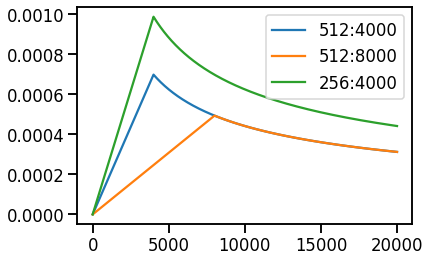

In [30]:
# Three settings of the lrate hyperparameters.
opts = [NoamOpt(512, 1, 4000, None), 
        NoamOpt(512, 1, 8000, None),
        NoamOpt(256, 1, 4000, None)]

plt.plot(np.arange(1, 20000), [[opt.rate(i) for opt in opts] for i in range(1, 20000)])
plt.legend(["512:4000", "512:8000", "256:4000"])

plt.show()

### Suavização de rótulos
Durante o treinamento, empregamos a [suavização de rótulos](https://arxiv.org/abs/1512.00567) com valor $ \epsilon_{ls} = 0.1 $. Isso prejudica a perplexidade, pois o modelo aprende a ser mais inseguro, mas melhora a precisão e a pontuação BLEU. 

Implementamos a suavização de rótulos usando a [perda de div KL](https://pytorch.org/docs/stable/generated/torch.nn.KLDivLoss.html). Em vez de usar uma distribuição de destino único ( one-hot target distribution ), criamos uma distribuição que tem *confiança* na palavra correta e no restante da massa de *suavização* distribuída por todo o vocabulário.

In [31]:
class LabelSmoothing(nn.Module):
    '''
    Implement label smoothing.
    '''
    def __init__(self, size, padding_idx, smoothing):
        super(LabelSmoothing, self).__init__()
        
        self.criterion = nn.KLDivLoss(size_average = False)
        self.padding_idx = padding_idx
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.size = size
        self.true_dist = None
        
    def forward(self, x, target):
        assert x.size(1) == self.size
        
        true_dist = x.data.clone()
        true_dist.fill_(self.smoothing / (self.size - 2))
        true_dist.scatter_(1, target.data.unsqueeze(1).long(), self.confidence)
        true_dist[:, self.padding_idx] = 0
        
        mask = torch.nonzero(target.data == self.padding_idx)
        
        if mask.dim() > 0:
            true_dist.index_fill_(0, mask.squeeze(), 0.0)
        
        self.true_dist = true_dist
        
        return self.criterion(x, Variable(true_dist, requires_grad = False))

A suavização de rótulos na verdade começa a penalizar o modelo se ele ficar muito confiante sobre uma determinada escolha.

C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


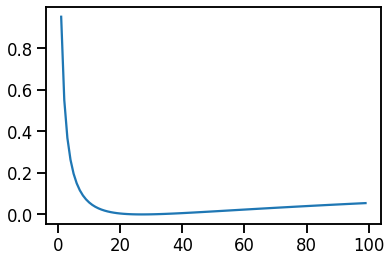

In [32]:
crit = LabelSmoothing(5, 0, 0.1)

def loss(x):
    d = x + 3
    
    predict = torch.FloatTensor([[0, x /d, 1/ d, 1/ d, 1/ d],])
    
    return crit(Variable(predict.log()),Variable(torch.LongTensor([1]))).data

plt.plot(np.arange(1, 100), [loss(x) for x in range(1, 100)])
plt.show()

## Teste
Podemos começar experimentando uma tarefa de cópia simples. Dado um conjunto aleatório de símbolos de entrada de um pequeno vocabulário, o objetivo é gerar de volta esses mesmos símbolos.

### Dados sintéticos

In [33]:
def data_gen(V, batch, nbatches):
    '''
    Generate random data for a src-tgt copy task.
    '''
    for i in range(nbatches):
        data = torch.from_numpy(np.random.randint(1, V, size = (batch, 10)))
        data[:, 0] = 1
        
        src = Variable(data, requires_grad = False)
        tgt = Variable(data, requires_grad = False)
        
        yield Batch(src, tgt, 0)

### Perda computacional

In [34]:
class SimpleLossCompute:
    '''
    A simple loss compute and train function.
    '''
    def __init__(self, generator, criterion, opt = None):
        self.generator = generator
        self.criterion = criterion
        self.opt = opt
        
    def __call__(self, x, y, norm):
        x = self.generator(x)
        
        loss = self.criterion(
            x.contiguous().view(-1, x.size(-1)), 
            y.contiguous().view(-1)
        )/ norm
        
        loss.backward()
        
        if self.opt is not None:
            self.opt.step()
            self.opt.optimizer.zero_grad()
        
        return loss.data * norm

### Decodificação gulosa

In [35]:
# Train the simple copy task.
criterion = LabelSmoothing(size = V, padding_idx = 0, smoothing = smoothing)

model = make_model(V, V, N = 2, d_model = d_model, d_ff = d_ff, h = h, dropout = dropout).to(device)
model_opt = NoamOpt(
    model.src_embed[0].d_model, 
    1, 400,
    torch.optim.Adam(model.parameters(), lr = lr, betas = betas, eps = eps)
)

for epoch in range(n_epochs):
    model.train()
    
    run_epoch(
        data_gen(V, 30, 20), model, 
        SimpleLossCompute(model.generator, criterion, model_opt)
    )
    
    model.eval()
    
    print(
        run_epoch(data_gen(V, 30, 5), model, 
        SimpleLossCompute(model.generator, criterion, None))
    )

C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch Step: 1 Loss: 3.162634 Tokens per Sec: 983.480957
Epoch Step: 1 Loss: 1.987137 Tokens per Sec: 1431.348389
tensor(1.9851)
Epoch Step: 1 Loss: 2.059660 Tokens per Sec: 1086.764160
Epoch Step: 1 Loss: 1.685951 Tokens per Sec: 1613.753662
tensor(1.7238)


Este código prevê uma tradução usando decodificação gulosa para simplificar.

In [36]:
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    memory = model.encode(src, src_mask)
    
    ys = torch.ones(1, 1).fill_(start_symbol).type_as(src.data)
    
    for i in range(max_len - 1):
        out = model.decode(
            memory, src_mask, 
            Variable(ys), 
            Variable(subsequent_mask(ys.size(1)).type_as(src.data))
        )
        
        prob = model.generator(out[:, -1])
        
        _, next_word = torch.max(prob, dim = 1)
        next_word = next_word.data[0]
        
        ys = torch.cat([
            ys, 
            torch.ones(1, 1).type_as(src.data).fill_(next_word)
        ], dim=1)
    
    return ys

In [37]:
model.eval()
src = Variable(torch.LongTensor([[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]]))
src_mask = Variable(torch.ones(1, 1, 10))

print(greedy_decode(model, src, src_mask, max_len = 10, start_symbol = 1))

tensor([[ 1,  4,  2,  3, 10,  8,  4,  2,  4,  3]])


## Exemplo real
Agora consideramos um exemplo do mundo real usando a tarefa de tradução alemão-inglês [Multi30k](https://paperswithcode.com/dataset/multi30k-1). Esta tarefa é muito menor do que a tarefa WMT considerada no artigo, mas ilustra todo o sistema.


In [38]:
%pip install torchtext --user
%pip install spacy --user
!python -m spacy download en
!python -m spacy download de

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\User\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\User\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


⚠ As of spaCy v3.0, shortcuts like 'en' are deprecated. Please use the full
pipeline package name 'en_core_web_sm' instead.
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


You should consider upgrading via the 'C:\Users\User\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


⚠ As of spaCy v3.0, shortcuts like 'de' are deprecated. Please use the full
pipeline package name 'de_core_news_sm' instead.
✔ Download and installation successful
You can now load the package via spacy.load('de_core_news_sm')


You should consider upgrading via the 'C:\Users\User\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


### Carregamento de dados
Vamos carregar o conjunto de dados usando torchtext e spacy para tokenização.

In [39]:
%pip install -U torch==1.8.0 torchtext==0.9.0

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\User\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


In [40]:
import torchtext
from torchtext.legacy import data, datasets
    
import spacy

spacy_de = spacy.load('de_core_news_sm')
spacy_en = spacy.load('en_core_web_sm')

In [41]:
def tokenize_de(text):
    return [tok.text for tok in spacy_de.tokenizer(text)]

def tokenize_en(text):
    return [tok.text for tok in spacy_en.tokenizer(text)]

In [42]:
BOS_WORD = '<start>'
EOS_WORD = '</end>'
BLANK_WORD = "<blank>"

SRC = torchtext.legacy.data.Field(
    tokenize = tokenize_de, 
    pad_token = BLANK_WORD
)

TGT = torchtext.legacy.data.Field(
    tokenize = tokenize_en, 
    init_token = BOS_WORD, 
    eos_token = EOS_WORD, 
    pad_token = BLANK_WORD
)

MAX_LEN = 100
MIN_FREQ = 2

train, val, test = torchtext.legacy.datasets.Multi30k.splits(
    exts = ('.de', '.en'), 
    fields = (SRC, TGT), 
    filter_pred = lambda x: len(vars(x)['src']) <= MAX_LEN and 
        len(vars(x)['trg']) <= MAX_LEN
)

SRC.build_vocab(train.src, min_freq = MIN_FREQ)
TGT.build_vocab(train.trg, min_freq = MIN_FREQ)

### Iteradores
Batching é muito importante para a velocidade. Queremos ter lotes muito bem divididos, com preenchimento (padding) absolutamente mínimo. Para fazer isso, temos que hackear um pouco o lote de torchtext padrão. Este código corrige seu lote padrão para garantir que pesquisamos frases suficientes para encontrar lotes apertados.

In [43]:
class MyIterator(data.Iterator):
    def create_batches(self):

        if self.train:
            
            def pool(d, random_shuffler):
                for p in data.batch(d, self.batch_size * 100):
                    p_batch = data.batch(
                        sorted(p, key = self.sort_key),
                        self.batch_size, 
                        self.batch_size_fn
                    )
                    
                    for b in random_shuffler(list(p_batch)):
                        yield b
            
            self.batches = pool(self.data(), self.random_shuffler)
            
        else:
            self.batches = []
            
            for b in data.batch(self.data(), self.batch_size, self.batch_size_fn):
                self.batches.append(sorted(b, key=self.sort_key))

In [44]:
def rebatch(pad_idx, batch):
    '''
    Fix order in torchtext to match ours
    '''
    src, trg = batch.src.transpose(0, 1), batch.trg.transpose(0, 1)
    
    return Batch(src, trg, pad_idx)

### Treinando o sistema

In [48]:
pad_idx = TGT.vocab.stoi["<blank>"]
 
model = make_model(len(SRC.vocab), len(TGT.vocab), 
    N = N, d_model = d_model, d_ff = d_ff, h = h, dropout = dropout).to(device)

criterion = LabelSmoothing(
    size = len(TGT.vocab), 
    padding_idx = pad_idx, 
    smoothing = 0.1
).to(device)


train_iter = MyIterator(
    train, 
    batch_size = BATCH_SIZE, 
    device = device,
    repeat = False, 
    sort_key = lambda x: (len(x.src), len(x.trg)),
    batch_size_fn = batch_size_fn, 
    train = True
)

valid_iter = MyIterator(
    val, 
    batch_size = BATCH_SIZE, 
    device = device,
    repeat = False, 
    sort_key = lambda x: (len(x.src), len(x.trg)),
    batch_size_fn = batch_size_fn, 
    train = False
)


In [49]:
model_opt = NoamOpt(
    model.src_embed[0].d_model, 
    1, 2000,
    torch.optim.Adam(model.parameters(), lr = lr, betas = betas, eps = eps)
)

for epoch in range(n_epochs):
    model.train()

    run_epoch(
        (rebatch(pad_idx, b) for b in train_iter), 
        model, 
        SimpleLossCompute(model.generator, criterion, opt = model_opt)
    )

    model.eval()
    
    loss = run_epoch(
        (rebatch(pad_idx, b) for b in valid_iter), 
        model, 
        SimpleLossCompute(model.generator, criterion, opt = None)
    )
    
    print(loss)

Epoch Step: 1 Loss: 7.602129 Tokens per Sec: 323.454651
Epoch Step: 51 Loss: 6.212976 Tokens per Sec: 320.629974
Epoch Step: 101 Loss: 5.266821 Tokens per Sec: 343.027924
Epoch Step: 151 Loss: 4.375191 Tokens per Sec: 340.382660
Epoch Step: 201 Loss: 4.617995 Tokens per Sec: 338.248444
Epoch Step: 251 Loss: 4.170762 Tokens per Sec: 338.701111
Epoch Step: 301 Loss: 3.905739 Tokens per Sec: 336.719482
Epoch Step: 351 Loss: 3.624804 Tokens per Sec: 340.884521
Epoch Step: 401 Loss: 4.198551 Tokens per Sec: 342.415375
Epoch Step: 451 Loss: 3.963381 Tokens per Sec: 343.917450
Epoch Step: 501 Loss: 3.728115 Tokens per Sec: 350.618042
Epoch Step: 551 Loss: 3.817764 Tokens per Sec: 358.346680
Epoch Step: 601 Loss: 3.601992 Tokens per Sec: 349.089050
Epoch Step: 651 Loss: 2.777131 Tokens per Sec: 329.257141
Epoch Step: 701 Loss: 3.185344 Tokens per Sec: 349.961090
Epoch Step: 751 Loss: 3.595632 Tokens per Sec: 359.884827
Epoch Step: 801 Loss: 3.264362 Tokens per Sec: 362.729675
Epoch Step: 851 L

Uma vez treinado, podemos decodificar o modelo para produzir um conjunto de traduções. Aqui nós simplesmente traduzimos a primeira sentença no conjunto de validação. Esse conjunto de dados é muito pequeno, então as traduções com busca gananciosa são razoavelmente precisas.

In [56]:
for i, batch in enumerate(valid_iter):
    src = batch.src.transpose(0, 1)[:1]
    src_mask = (src != SRC.vocab.stoi["<blank>"]).unsqueeze(-2)
    
    out = greedy_decode(
        model, 
        src, 
        src_mask, 
        max_len = 60, 
        start_symbol = TGT.vocab.stoi["<start>"]
    )
    
    print("Translation:", end = "\t")
    
    for i in range(1, out.size(1)):
        translation = TGT.vocab.itos[out[0, i]]
        
        if translation == "</end>": break
        print(translation, end = " ")
    
    print("\nTarget:", end = "\t")
    
    for i in range(1, batch.trg.size(0)):
        target = TGT.vocab.itos[batch.trg.data[i, 0]]
        
        if target == "</end>": break
        print(target, end = " ")

    score = sentence_bleu(translation, target)
    
    print("\nBLEU score: " + str(score))
    break

Translation:	A group of young students are using their hands . 
Target:	Farmers are performing their <unk> during the day . 
BLEU score: 1.821831989445342e-231


## Experimentos

In [57]:
%pip install wget
!python -m wget https://s3.amazonaws.com/opennmt-models/en-de-model.pt

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\User\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.



Saved under en-de-model.pt


In [58]:
model, SRC, TGT = torch.load("en-de-model.pt")

C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\serialization.py:656: SourceChangeWarning: source code of class 'torch.nn.modules.container.ModuleList' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\serialization.py:656: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\serialization.py:656: SourceChangeWarning: source code of class 'torch.nn.modules.dropout.Dropout' has cha

In [64]:
model.eval()

sent = "▁The ▁log ▁file ▁can ▁be ▁sent ▁secret ly ▁with ▁email ▁or ▁FTP ▁to ▁a ▁specified ▁receiver".split()

src = torch.LongTensor([[SRC.stoi[w] for w in sent]])
src = Variable(src)
src_mask = (src != SRC.stoi["<blank>"]).unsqueeze(-2)

out = greedy_decode(
    model, 
    src, 
    src_mask, 
    max_len = 60, 
    start_symbol = TGT.stoi["<s>"]
)

print("Translation:", end = "\t")

trans = "<s> "

for i in range(1, out.size(1)):
    sym = TGT.itos[out[0, i]]
    
    if sym == "</s>": break
    
    trans += sym + " "

print(trans)

score = sentence_bleu(sent, trans)

print("\nBLEU score: " + str(score))


Translation:	<s> ▁Die ▁Protokoll datei ▁kann ▁ heimlich ▁per ▁E - Mail ▁oder ▁FTP ▁an ▁einen ▁bestimmte n ▁Empfänger ▁gesendet ▁werden . 

BLEU score: 0.05900959885911068
